## Define a GLM and generate synthetic data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<AxesSubplot:>

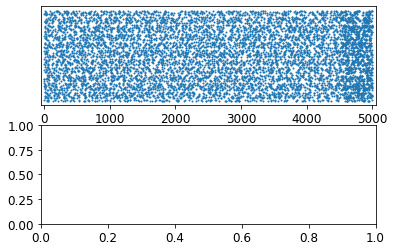

In [82]:
import matplotlib.pyplot as plt
import torch

from examples_utils import PALETTE, plot_filter, set_style
from kernel.base import Kernel
from kernel.fun import KernelFun
from mmdglm.glm.base import GLM
from mmdglm.utils import plot_spiketrain

%load_ext autoreload
%autoreload 2

set_style()

torch.manual_seed(9)


# Define history filter using a basis of raised cosines
dt = 1
n, last_peak = 2, 10
stim_filter_true = Kernel.orthogonalized_raised_cosines(dt, last_peak, n, 4, a=1e0, weight=torch.tensor([-1e0, -1e0]))
hist_filter_true = KernelFun.exponential(tau=torch.tensor([50.]), weight=torch.tensor([-1e0]))
glm_true = GLM(bias=-4, hist_kernel=hist_filter_true, stim_kernel=stim_filter_true)

# Generate synthetic data
stim = torch.randn(5000, 80)
t = torch.arange(len(stim))
log_lam, mask_spikes = glm_true.sample(t, stim=stim, shape=(1,))

fig, (ax1, ax2) = plt.subplots(figsize=(6, 4), nrows=2)
plot_spiketrain(t, mask_spikes, ax=ax1)
# ax2.plot(t, stim)

In [83]:
stim_filter = Kernel.orthogonalized_raised_cosines(dt, last_peak, n, 4, a=1e0)
hist_filter = KernelFun.exponential(tau=torch.tensor([50.]), weight=torch.tensor([-2e0]))
glm = GLM(bias=-5, hist_kernel=hist_filter.clone(), stim_kernel=stim_filter.clone())

num_epochs = 400
optim = torch.optim.Adam(glm.parameters(), lr=1e-2, betas=(0, 0.))
loss, metrics_list = glm.fit(t, mask_spikes, stim=stim, num_epochs=num_epochs, optim=optim)

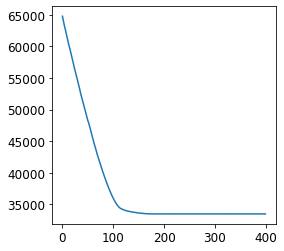

In [84]:
plt.plot(loss)

In [85]:
from mmdglm.metrics import negative_log_likelihood
negative_log_likelihood(dt, mask_spikes, glm.log_conditional_intensity(t, mask_spikes))

tensor(41856.9922, grad_fn=<NegBackward>)

In [86]:
negative_log_likelihood(dt, mask_spikes, glm_true.log_conditional_intensity(t, mask_spikes))

tensor(44624.8711, grad_fn=<NegBackward>)

In [87]:
# log_lam = glm.log_conditional_intensity(t, mask_spikes[:, :1], stim=None, full_output=False)
# t_spikes = [t[mask_spikes[:, i]] for i in range(1)]

# fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=2, sharex=True)
# ax1.plot(t, log_lam.detach())
# ax2.eventplot(t_spikes)
# ax1.set_xlim(60, 80)
# ax1.set_ylim(-5, -4)

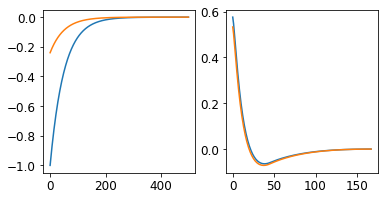

In [89]:
fig, (ax1, ax2) = plt.subplots(figsize=(6, 3), ncols=2)
plot_filter(ax1, hist_filter_true, gain=False)
plot_filter(ax1, glm.hist_kernel, gain=False)

plot_filter(ax2, stim_filter_true, gain=False)
plot_filter(ax2, glm.stim_kernel, gain=False)

In [6]:
# # Load data
# data = torch.load('./data/synthetic_data.pt')

# Define basis with a single exponential
dt = 1
support_range = torch.arange(0, 100, dt).unsqueeze(1)
tau = torch.tensor([10.]).unsqueeze(0)
basis = torch.exp(-support_range / tau)

# Define Kernels and GLM
stim_kernel = Kernel(basis=basis)
hist_kernel = Kernel(basis=basis)
glm = GLM(bias=-5., stim_kernel=stim_kernel, hist_kernel=hist_kernel)

# Define optimizer and fit
optim = torch.optim.Adam(glm.parameters(), lr=5e-3, betas=(0, 0.9))
loss, _ = glm.fit(data['t'], data['mask_spikes'], stim=data['stim'], num_epochs=750, optim=optim, verbose=True)

# Plot negative log-likelihood
fig, ax = plt.subplots()
ax.plot(loss)
ax.set_ylabel('negative log-likelihood')

NameError: name 'data' is not defined

## Display parameters


Bias is  Parameter containing:
tensor([-3.2048], requires_grad=True)


Text(0, 0.5, 'history kernel')

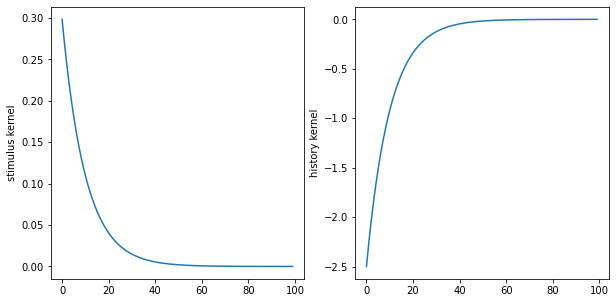

In [2]:
# Display parameters
t_ker = torch.arange(0, 100, 1)

print('\nBias is ', glm.bias)
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(t_ker, glm.stim_kernel.evaluate(t_ker).detach())
ax2.plot(t_ker, glm.hist_kernel.evaluate(t_ker).detach())
ax1.set_ylabel('stimulus kernel')
ax2.set_ylabel('history kernel')